<a href="https://colab.research.google.com/github/Agbeli/Solution_2/blob/main/Part_2_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Sequences Analysis

- This is to perform comparative analysis with different classifiers based on K-mers approach of feature extraction from sequence dataset. 

- Viral sequences of HIV-1 dataset. 


#### Reasons for HIV-1 dataset:

- The size fo the 16S ribosomal RNA sequence datasets are huge to be precess with the limited resources at hand now. 
- I had to leverage on colab for the second questions. 
- All the datasets I got in the course of search where not annotated and I needed time to explore more in order to understand de-facto standard for annotating such dataset. 


#### Difference between the naive bayes and Logistic Regression:

Naive bayes is linear classifier using Bayes Theorem and strong independence condition among features. Given input data of n features $x_{1},x_{2},\cdots,x_{n}$. Naive bayes predict the probabilistic outcome say $Y$ given the input features. This model is term as generative model. 

Logistic Regression is also a linear classifier that mostly used in cases where there is boolean outcome say $\{0,1\}$. The probability outcome is parametric function given by the sigmoid function. This is a discriminative model. There is multiclass logistic regression use for more two outcomes. 


References:

- https://scikit-learn.org
- http://castor.bioinfo.uqam.ca/index.php?castor=main

In [1]:
### mount the drive in order to have access to my drive.... 
from google.colab import  drive 
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/Yaamachi"

/content/drive/MyDrive/Yaamachi


In [3]:
!pip install -U biopython

     |████████████████████████████████| 2.3MB 8.7MB/s 


In [1]:
import pandas as pd 
import numpy as np 
import scipy 
import sklearn
from matplotlib import pyplot as plt 
import os
import sys
import csv
from Bio import SeqIO
import re

In [2]:
def generateDataset(fasta_file,csv_file):

  data = list()

  with open(csv_file,"r") as file:
    reader = dict(csv.reader(file))
  
  for record in SeqIO.parse(fasta_file,"fasta"):
    if record.id in reader: 
      data.append([record.id, record.seq.upper(),reader[record.id]])

  return data 

In [3]:
fasta_file = "/content/drive/MyDrive/Yaamachi/CASTOR_KRFE/Input/HIVGRPCG/data.fasta"
target_file = "/content/drive/MyDrive/Yaamachi/CASTOR_KRFE/Input/HIVGRPCG/target.csv"

In [4]:
dataset = generateDataset(fasta_file=fasta_file,csv_file=target_file)

### Exploratory Analysis 

- This is to have an insight of the sequences in the dataset. There are any form of imbalance scenarios in the dataset. 
- To have a fair distribution of the labels in the dataset. 
- Visualize the nature of distribution in the dataset.

#### Results:

- There is high level of imbalance scenario in the dataset. 
- I have to consider using k-folds cross-validation. 

In [5]:
### create a dataframe
from collections import defaultdict 
frequency_count = defaultdict(int)

for i in dataset:
  if i[2] in frequency_count.keys():
    frequency_count[i[2]] += len(i[1])
  else:
    frequency_count[i[2]] = 0

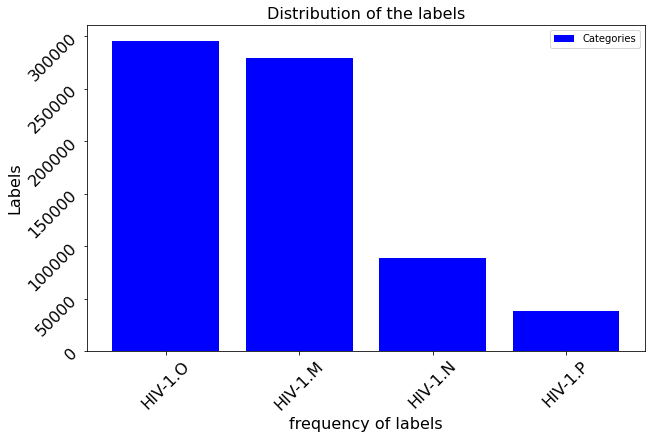

In [6]:
d = sorted(frequency_count.items(),key=lambda x:x[1],reverse=True)
x , y = zip(*d)  ## unpack the 
plt.figure(figsize=(10,6))
plt.bar(x,y,label="Categories",color="blue")
plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=16, rotation=45)
plt.title("Distribution of the labels",fontsize=16)
plt.ylabel("Labels",fontsize=16)
plt.xlabel("frequency of labels",fontsize=16)
plt.legend(loc="best")
plt.show()

In [7]:
# Function generating the k_mers belonging to the sequences 
def generate_K_mers(data, k):
	# List of k-mer
	K_mers = []
	dict = {}

	# Initialization of the dictionary
	for d in data:
		for i in range(0, len(d[1]) - k + 1, 1): dict[d[1][i:i + k]] = 0;
		
	# Remove patterns not used
	for key in dict.keys():
		if bool(re.match('^[ACGT]+$', str(key))) == True: K_mers.append(str(key))
	
	# Return K_mers
	return K_mers

In [8]:
###
kmers_data = generate_K_mers(dataset,4)

#### Generate Matrice 

In [9]:
# Function of feature and class matrix generation
def generateMatrice(data, K_mer, k):
	# Variables
	X = []
	y = []

	# Generate K-mer dictionnary
	X_dict = {}
	for i, e in enumerate(K_mer):  X_dict[e] = 0;
	# Generates X (matrix attributes)
	for d in data:
		x = []
		x_dict =  X_dict.copy()

		# Count K-mer occurences (with overlaping)
		for i in range(0, len(d[1]) - k + 1, 1):
			try: x_dict[d[1][i:i + k]] = x_dict[d[1][i:i + k]] + 1; 
			except: pass
		
		# Get only occurences from dictionnary
		for value in x_dict:
			x.append(x_dict.get(value))
		X.append(x)

	# Generates y (Matrix class) if csv file exist
	if len(data[0]) == 3: 
		for i in data: y.append(i[2])
	
	# Return matrices X and y  (matrix attributes and matrix class)
	return X, np.array(y)

In [10]:
X_dataset , y = generateMatrice(dataset,kmers_data,4)

### 10 -folds cross-validations

- From the results, we observe that both logistic regression and Multinomial Naive bayes have a higher f1-score compare to the other two bayes models. 

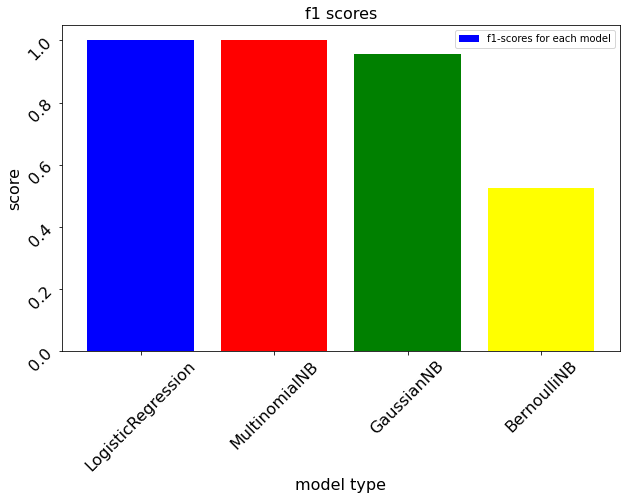

In [29]:
##### import the libraries required 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,classification_report
from sklearn.model_selection import cross_val_predict
import warnings

warnings.filterwarnings("ignore")
###### 
models = {"LogisticRegression":LogisticRegression,"GaussianNB":GaussianNB,
            "MultinomialNB":MultinomialNB,"BernoulliNB":BernoulliNB}
f1_scores = dict()
### perform 10-fold cross-validation for each models 
cv = StratifiedKFold(n_splits=10)
for name , model in models.items():
  y_pred = cross_val_predict(estimator= model(),X = X_dataset,y = y,cv = cv)
  f1_scores[name] = f1_score(y,y_pred,average="weighted")


d = sorted(f1_scores.items(),key=lambda x:x[1],reverse=True)
x , y = zip(*d)  ## unpack the 
plt.figure(figsize=(10,6))
plt.bar(x,y,label="f1-scores for each model",color=["blue","red","green","yellow"])
plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=16, rotation=45)
plt.title("f1 scores",fontsize=16)
plt.ylabel("score",fontsize=16)
plt.xlabel("model type",fontsize=16)
plt.legend(loc="best")
plt.show()  
